In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Load pretrained model and test data

In [2]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [3]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [4]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [5]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [6]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
X_test = np.log(X_test_raw)
# X_test = np.expand_dims(X_test, axis = -1)
print(X_test.shape)

(800, 640, 128)


### Extract embeddings from the concat layer of the model

In [7]:
layer_name = 'dense1'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_test)

In [8]:
print(intermediate_output.shape)

(800, 64)


In [9]:
# print(intermediate_output[:2])

### Cluster using K means

In [10]:
from sklearn.cluster import KMeans, SpectralClustering

In [11]:
kmeans = KMeans(n_clusters=8, init='random', verbose =1).fit(intermediate_output)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 3433.5354
start iteration
done sorting
end inner loop
Iteration 1, inertia 2805.9912
start iteration
done sorting
end inner loop
Iteration 2, inertia 2601.613
start iteration
done sorting
end inner loop
Iteration 3, inertia 2521.6172
start iteration
done sorting
end inner loop
Iteration 4, inertia 2470.8357
start iteration
done sorting
end inner loop
Iteration 5, inertia 2456.0308
start iteration
done sorting
end inner loop
Iteration 6, inertia 2447.3564
start iteration
done sorting
end inner loop
Iteration 7, inertia 2444.024
start iteration
done sorting
end inner loop
Iteration 8, inertia 2441.478
start iteration
done sorting
end inner loop
Iteration 9, inertia 2436.269
start iteration
done sorting
end inner loop
Iteration 10, inertia 2433.0334
start iteration
done sorting
end inner loop
Iteration 11, inertia 2431.047
start iteration
done sorting
end inner loop
Iteration 12, inertia 2430.47
start

In [12]:
labels = kmeans.labels_
labels.shape

(800,)

In [13]:
print(labels)

[0 1 7 7 1 1 7 3 6 0 0 0 3 1 0 7 0 3 1 1 3 1 1 5 6 1 7 1 6 1 3 6 6 6 7 3 3
 6 0 7 3 7 3 6 6 2 6 7 3 0 3 0 3 3 3 4 3 2 7 7 7 0 5 5 4 0 0 3 0 6 7 3 3 0
 3 0 4 0 4 6 3 0 3 0 7 3 0 0 0 3 3 4 3 3 0 3 2 3 6 3 3 5 0 5 5 0 2 5 2 1 1
 1 1 1 1 7 6 7 6 0 1 7 3 3 0 0 3 0 6 3 0 0 3 0 0 5 0 0 7 7 6 0 6 0 4 5 2 7
 1 1 5 0 5 0 1 3 0 2 0 7 3 1 1 1 1 7 1 2 0 5 2 3 2 3 5 1 2 1 0 3 0 3 0 0 7
 1 0 7 1 7 1 5 7 0 1 1 5 1 4 7 4 4 4 7 7 4 7 7 7 7 7 4 7 1 7 7 4 7 7 7 7 6
 7 7 7 3 3 2 1 7 3 3 3 3 3 7 3 3 7 3 7 0 0 3 3 7 0 1 5 5 3 1 5 7 7 7 3 7 7
 1 1 1 7 0 7 4 7 7 7 7 7 7 7 7 7 7 0 0 0 5 1 6 3 6 3 2 0 4 1 4 2 5 2 2 3 6
 0 3 3 3 0 0 3 3 6 4 0 3 2 6 6 6 6 1 2 4 7 5 7 7 7 4 7 7 7 7 7 7 3 7 1 1 6
 1 4 3 3 3 0 3 3 3 3 0 1 3 1 5 1 2 2 2 2 0 2 0 2 1 3 2 4 7 3 1 2 3 3 3 1 0
 5 1 1 2 1 1 1 5 0 1 1 1 3 2 2 6 5 0 1 2 2 2 2 0 5 1 4 4 0 5 1 5 0 1 3 6 7
 5 5 3 3 3 0 0 6 0 0 0 5 0 1 0 5 1 0 0 5 0 1 3 3 3 3 5 1 5 5 6 5 1 5 2 1 5
 4 6 7 7 3 6 7 0 0 3 4 6 4 4 4 4 2 2 6 0 1 1 2 2 0 5 0 0 7 7 7 0 0 5 5 5 2
 0 4 4 0 0 4 6 1 1 6 0 0 

### Evaluate the output from K-means 

#### Adjusted Rand Index

In [14]:
from sklearn.metrics import adjusted_rand_score

In [15]:
adjusted_rand_score(y_test, labels)

0.21950611088064412

#### Try different number of clusters

In [16]:
from sklearn.metrics import silhouette_score

for cluster in range(2,10):
    kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
    labels = kmeans.labels_
    score = silhouette_score(intermediate_output, labels, metric='euclidean')
    print("Cluster number and Score is: ", cluster, score)

Cluster number and Score is:  2 0.27497894
Cluster number and Score is:  3 0.27732375
Cluster number and Score is:  4 0.27161542


/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Cluster number and Score is:  5 0.274734
Cluster number and Score is:  6 0.29575256
Cluster number and Score is:  7 0.28825805


/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Cluster number and Score is:  8 0.30210757
Cluster number and Score is:  9 0.28578967


/home/priya/miniconda3/envs/exptt/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:259: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


### Visualizations

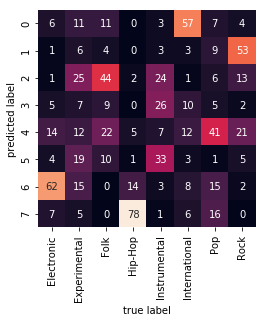

In [17]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 8
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');



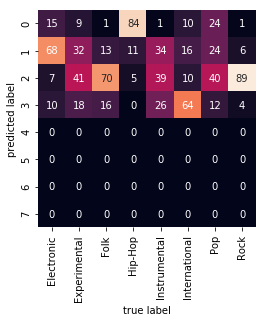

In [19]:
### 4 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns
cluster = 4
kmeans = KMeans(n_clusters=cluster, init='random', verbose =0).fit(intermediate_output)
labels = kmeans.labels_

mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');

